In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler

In [2]:
import yfinance as yf
from cachetools import cached,LRUCache

In [3]:
@cached(cache=LRUCache(maxsize=30))
def getData(ticker):
    return yf.download(ticker, period="max")

### Set ticker and Predict Target

In [4]:
ticker = 'TSLA'
pred_target = 'Adj Close'
test_pr = 0.05

### get live data into dataframe

In [5]:
df = getData(ticker)
df.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-05-03,703.799988,706.000000,680.500000,684.900024,684.900024,27043100
2021-05-04,678.940002,683.450012,657.700012,673.599976,673.599976,29739300
2021-05-05,681.059998,685.299988,667.340027,670.940002,670.940002,21901900
2021-05-06,680.760010,681.020020,650.000000,663.539978,663.539978,27784600
2021-05-07,665.799988,690.000000,660.219971,672.369995,672.369995,23422100


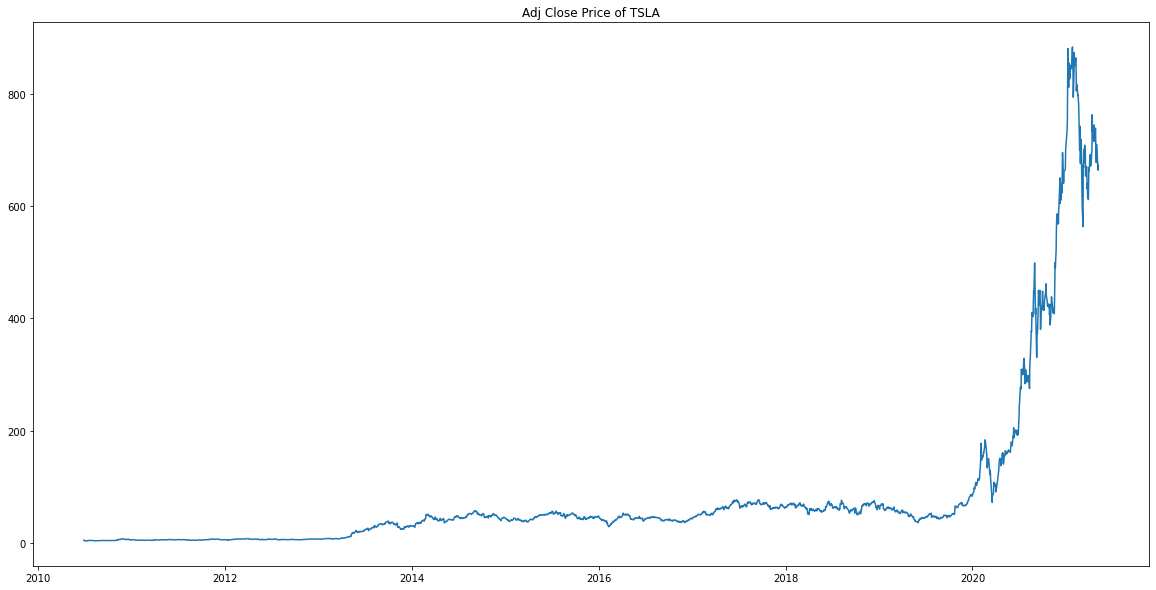

In [6]:
plt.title(pred_target+' Price of '+ticker)
plt.plot(df["Adj Close"],label=pred_target+' Price of '+ticker)

In [7]:
new_dataset = df[[pred_target]]

In [8]:
new_dataset

,Adj Close
Date,
2010-06-29,4.778000
2010-06-30,4.766000
2010-07-01,4.392000
2010-07-02,3.840000
2010-07-06,3.222000
...,...
2021-05-03,684.900024
2021-05-04,673.599976
2021-05-05,670.940002


### Train & Test splitting

In [9]:
split_point = min(len(new_dataset)-60,int(len(new_dataset)*(1-test_pr)))

## Normalize new filtered dataset

In [10]:
scaler=MinMaxScaler(feature_range=(0,1))
final_dataset=new_dataset.values
train_data=final_dataset[0:split_point,:]
valid_data=final_dataset[split_point:,:]
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)
x_train_data,y_train_data=[],[]
for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

## Build and Train LSTM model

In [11]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(5))
lstm_model.add(Dense(1))
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 5)                 255       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 30,861
Trainable params: 30,861
Non-trainable params: 0
_________________________________________________________________


## Train LSTM

In [12]:
lstm_model.fit(x_train_data,y_train_data,epochs=10,batch_size=100,verbose=2)
#lstm_model.save("stock_model.h5")

Epoch 1/10
26/26 - 4s - loss: 8.4575e-04
Epoch 2/10
26/26 - 1s - loss: 1.8408e-04
Epoch 3/10
26/26 - 1s - loss: 1.2625e-04
Epoch 4/10
26/26 - 1s - loss: 1.0604e-04
Epoch 5/10
26/26 - 1s - loss: 1.0242e-04
Epoch 6/10
26/26 - 1s - loss: 9.0951e-05
Epoch 7/10
26/26 - 1s - loss: 8.7302e-05
Epoch 8/10
26/26 - 1s - loss: 9.4724e-05
Epoch 9/10
26/26 - 1s - loss: 8.5992e-05
Epoch 10/10
26/26 - 1s - loss: 8.6915e-05


### Sample LSTM prediction

In [13]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

C:\ProgramData\Anaconda3\envs\Pin6\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


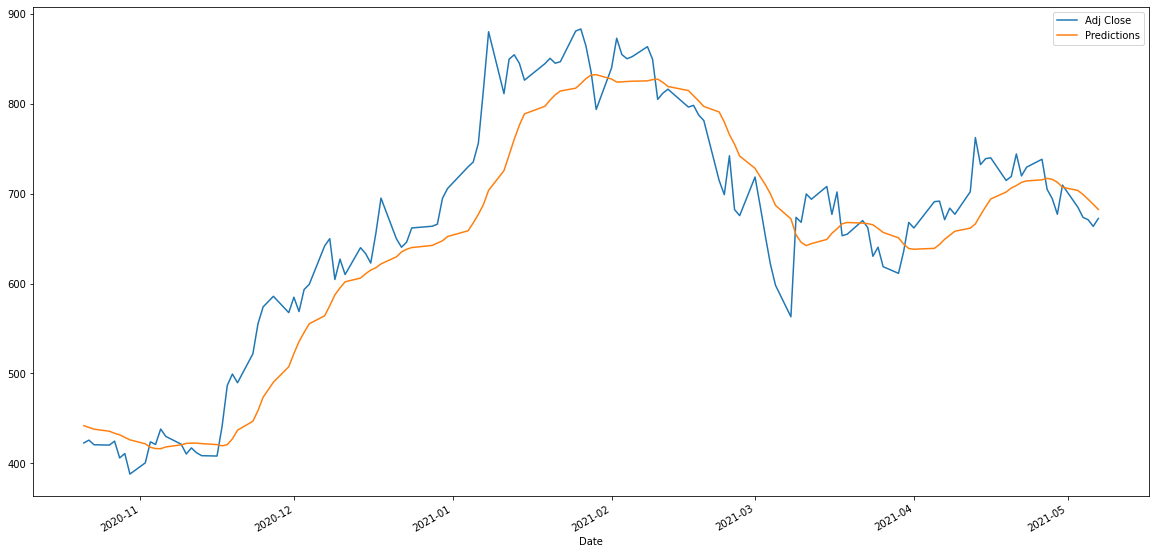

In [14]:
train_data=new_dataset[:split_point]
valid_data=new_dataset[split_point:]
valid_data['Predictions']=predicted_closing_price
#plt.plot(train_data[pred_target])
#plt.plot(valid_data[[pred_target,"Predictions"]],label=['a','b'])
#a = train_data.plot()
b = valid_data.plot()

In [15]:
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

In [16]:
actual,predicted = valid_data[pred_target],valid_data['Predictions']
metric = {'Metric':['max error','mean absolute error','mean absolute percentage error','mean squared error'],
         'Score':[max_error(actual,predicted),mean_absolute_error(actual,predicted),mean_absolute_percentage_error(actual,predicted),mean_squared_error(actual,predicted)]}
met = pd.DataFrame(metric)
met

,Metric,Score
0,max error,176.409180
1,mean absolute error,37.990041
2,mean absolute percentage error,0.057277
3,mean squared error,2337.251430
